In [1]:
from IPython.display import clear_output
import torch 
import torchvision 
import quantus
clear_output()

In [2]:
import pathlib
import random
import copy
import gc
import numpy as np
# import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import quantus
import warnings
from torchvision import datasets, transforms
import os
import torch.nn as nn
import json
sns.set() 

# Enable GPU. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
clear_output()

In [3]:
with open('data/results.json', 'r') as f:
    results = json.load(f)
xai_methods = ['Grad_CAM', 'Grad_CAM++', 'Relevance_CAM']
metrics = ['Faithfulness','Robustness','Axiomatic','Complexity','Randomisation']

In [4]:
from pandas import DataFrame

# Postprocessing of scores: to get how the different explanation methods rank across criteria.
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric in metrics:
        results_agg[method][metric] = np.mean(results[method][metric])

df = DataFrame.from_dict(results_agg)
df = df.T.abs()
df

,Faithfulness,Robustness,Axiomatic,Complexity,Randomisation
Grad_CAM,0.004027,3281.755555,1.8,10.656896,1.0
Grad_CAM++,0.011312,3587.090095,2.0,10.689298,1.0
Relevance_CAM,0.015429,3518.596257,1.9,10.623426,1.0


In [5]:
# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, df.columns != 'Robustness'].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Faithfulness,Axiomatic,Complexity,Randomisation,Robustness
Grad_CAM,1.0,1.0,2.0,2.0,3.0
Grad_CAM++,2.0,3.0,3.0,2.0,1.0
Relevance_CAM,3.0,2.0,1.0,2.0,2.0


In [6]:
# Plotting configs.
sns.set(font_scale=1.5)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

In [7]:
# Plotting specifics.
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

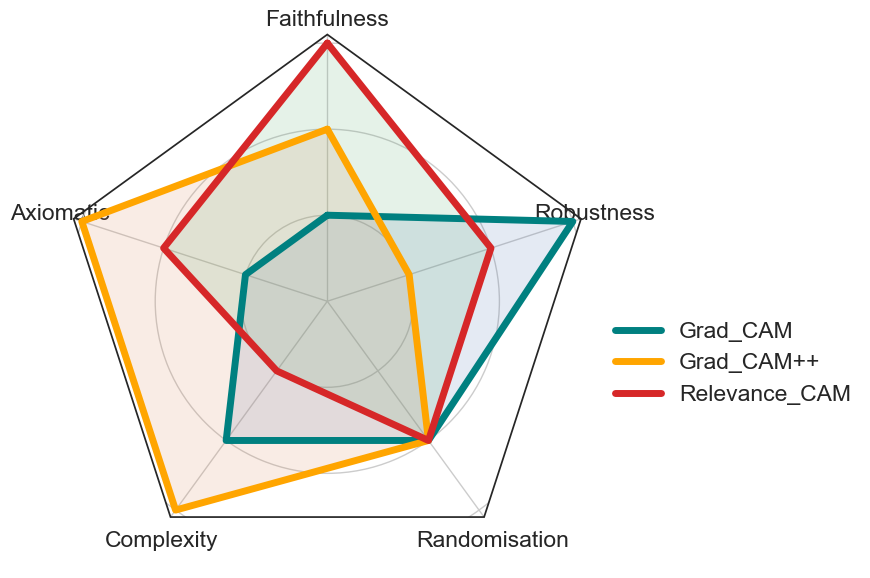

In [16]:
# Make spyder graph!
colours_order = ["#008080", "#FFA500", "#d62728"]

data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Axiomatic', '\nComplexity', '\nRandomisation', 'Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
# ax.set_title("Quantus: Summary of Explainer Quantification",  position=(0.5, 1.1), ha='center', fontsize=20)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()